In [1]:
library(rtracklayer)
library(GenomicRanges)
library(ggplot2)
library(vioplot)
library(ggdist)
library(ggforce)
library(dplyr)
library(tidyr)
library(gridExtra)
library(ggpubr)
library(reshape2)
library(ggrepel)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: sm

Package 'sm', version 2.2-5.7: type help(sm) 

In [2]:
files1 <- list.files("/gpfs/gsfs12/users/wangy80/TK77/ARTDeco_stress_output/dogs",pattern="*out.dogs.bed")
files2 <- list.files("/gpfs/gsfs12/users/wangy80/TK77/ARTDeco_Output_v2/dogs",pattern="*out.dogs.bed")

In [3]:
dir1 <- "/gpfs/gsfs12/users/wangy80/TK77/ARTDeco_stress_output/dogs/"
dir2 <- "/gpfs/gsfs12/users/wangy80/TK77/ARTDeco_Output_v2/dogs/"

In [4]:
files<- c(paste0(dir1,files1),paste0(dir2,files2))

In [5]:
load(paste0(getwd(), "/MILI.prepach.clusters_forThenia.Rdata")) #MILI.prepach.clusters
MILI.prepach.clusters <- MILI.prepach.clusters$regions

In [6]:
write.table(as.data.frame(MILI.prepach.clusters),"MILI.prepach.clusters.bed",sep="\t",quote=F,row.names=F)

In [7]:
print(paste("Number of MILI prepachytene clusters:", length(MILI.prepach.clusters)))

[1] "Number of MILI prepachytene clusters: 28626"


In [8]:
#sort and rank prepachytene clusters
MILI.prepach.clusters <- MILI.prepach.clusters[order(-MILI.prepach.clusters$all_reads_primary_alignments_FPM)]
MILI.prepach.clusters$Rank <- seq(1: length(MILI.prepach.clusters))

In [9]:
top1000 <- MILI.prepach.clusters[1:1000,]

In [10]:
sta <- data.frame()

In [11]:
for(i in 1:length(files)){
    samplename <- gsub("_vSplGTF","",gsub("^.*totalRNA_mouse_","",gsub("^.*mmu_NIH3TR_","",gsub("_Aligned.sortedByCoord.out.dogs.bed","",files[i]))))
    data <- import(files[i], format="bed")
    data$length <- width(data)
    data$sample <- samplename
    print(paste(samplename, length(data)))
    sta[i,1] <- samplename
    sta[i,2] <- length(data)
    ## overlap with PiRNA clusters
    df <- as.data.frame(data)
    df$ID <- paste0(df$seqnames,":",df$start,"-",df$end)
    overlap <- as.data.frame(subsetByOverlaps(data, top1000,type=c("any"), ignore.strand=FALSE, invert=FALSE))
    overlap$ID <- paste0(overlap$seqnames,":",overlap$start,"-",overlap$end)
    df$PiCluster <- ifelse(df$ID %in% overlap$ID, "yes", "no")
    assign(samplename,df)
}

[1] "heatshock_SRR5558715 3544"
[1] "heatshock_SRR5558716 4179"
[1] "osmstress_SRR5558719 6296"
[1] "osmstress_SRR5558720 5782"
[1] "oxistress_SRR5558717 5984"
[1] "oxistress_SRR5558718 5993"
[1] "untreated_SRR5558713 4249"
[1] "untreated_SRR5558714 4335"
[1] "control_P42_SRR765631 1566"
[1] "pach_P14_SRR7760359 2383"
[1] "prepach_E16.5_SRR11916388 1512"


In [12]:
### number of DoGS for each sample

sta$V2 <- as.numeric(sta$V2)
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

p1<-ggplot(data=sta, aes(x=V1, y=V2)) +
  geom_bar(stat="identity",fill="steelblue") + 
  coord_flip() +
  geom_text(aes(label=V2), hjust=1.2, size=3,color="white")+
  xlab("sample") +
  ylab("count") +
  ggtitle("number of DoGs") +
  theme_minimal()

png 
  2

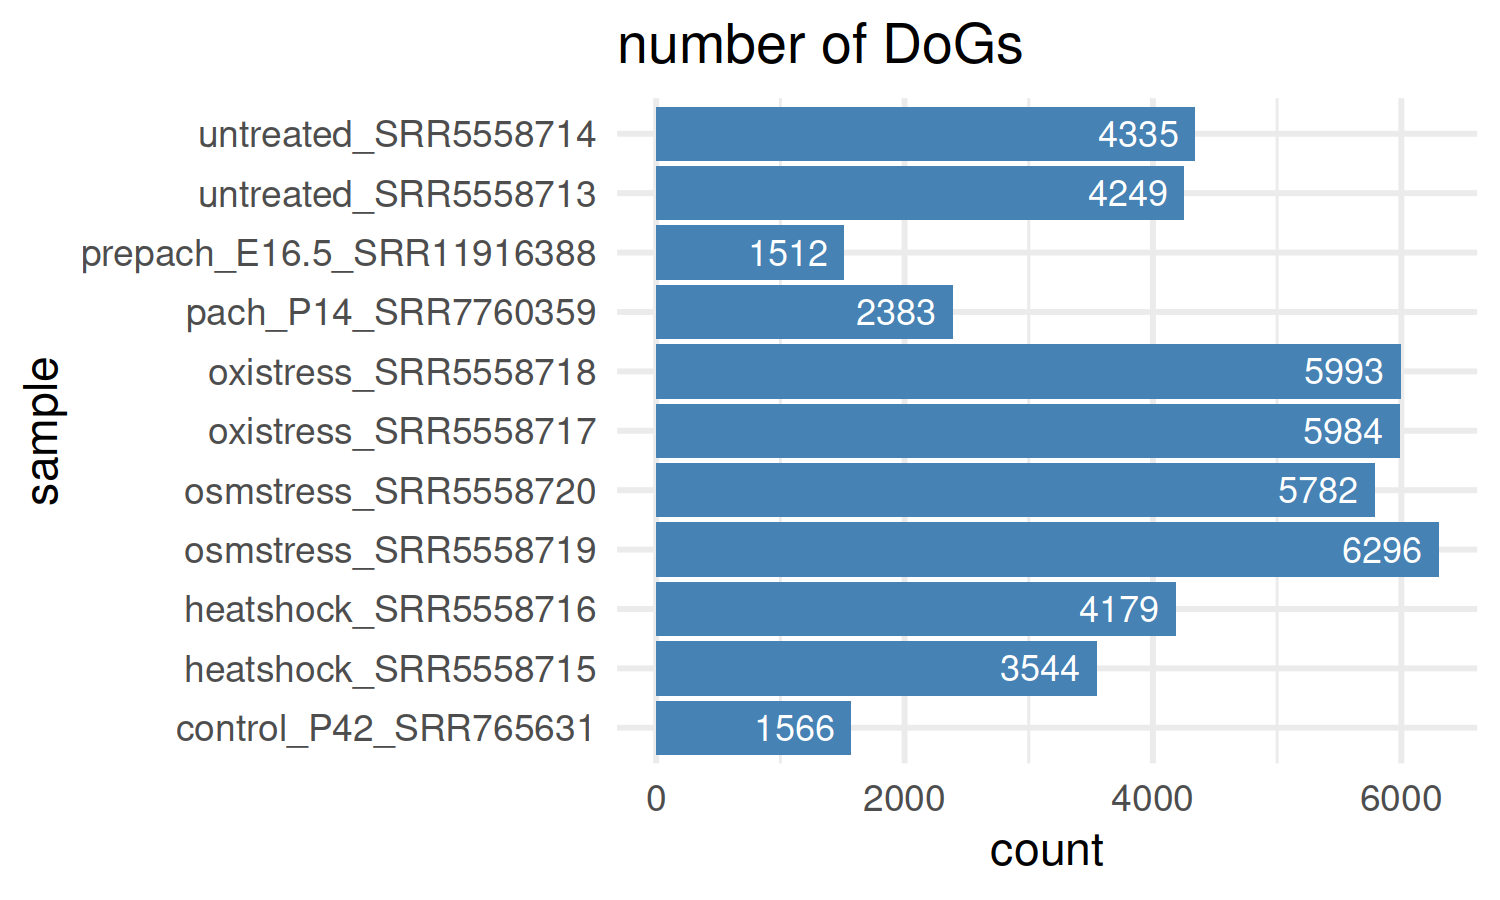

In [13]:
pdf("number_of_DoGs_barplot.pdf",height=3,width=5)
p1
dev.off()
p1

### reads for each sample

In [14]:
## linux
# for i in `ls *bam`; do file=`basename $i _Aligned.sortedByCoord.out.bam`; n=`samtools view $i|wc -l`; echo -e "$file $n" >>sta.txt; done

In [15]:
reads <- read.delim("/data/wangy80/TK77/FranziToYuejunReadthrough/sta.txt",sep=" ",header=F)
names(reads) <- c("filename","readcount")

In [16]:
reads$sample <- gsub("_vSplGTF","",gsub("totalRNA_mouse_","",gsub("mmu_NIH3TR_","",reads$filename)))

In [17]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)
p2<-ggplot(data=reads, aes(x=sample, y=readcount)) +
  geom_bar(stat="identity",fill="steelblue") + 
  coord_flip() +
  geom_text(aes(label=readcount), hjust=0.6, size=1.5,color="black")+
  xlab("sample") +
  ylab("readcount") +
  ggtitle("number of reads") +
  theme_minimal()

png 
  2

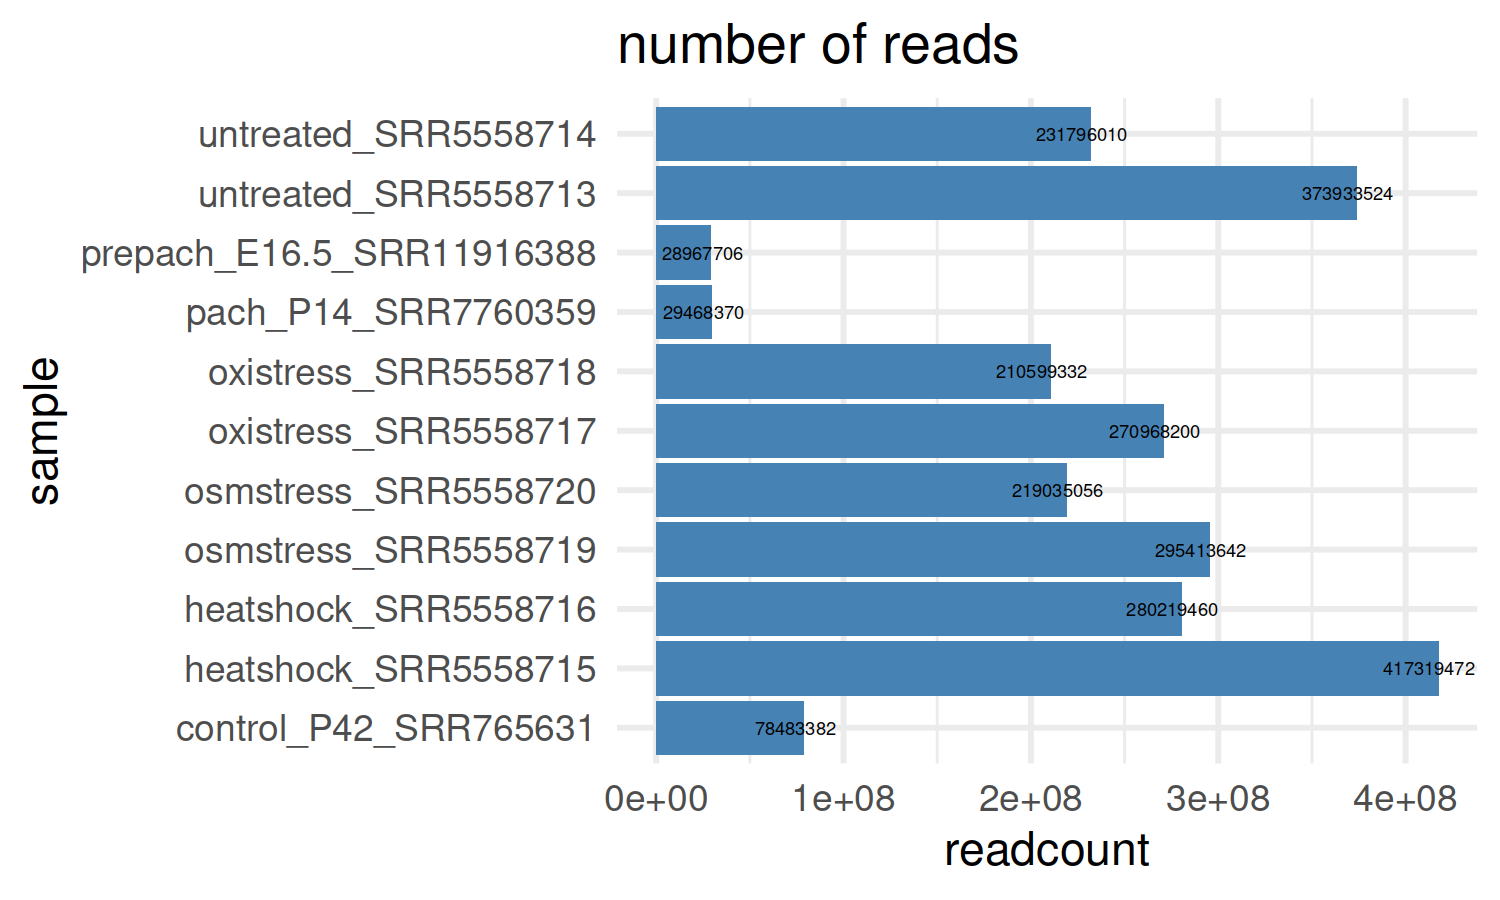

In [18]:
pdf("number_of_reads_barplot.pdf",height=3,width=5)
p2
dev.off()
p2

#### Get total expressed genes

#### stress

In [19]:
#load gene.exp.fpkm.txt file
file_geneExprFPKM <- "/gpfs/gsfs12/users/wangy80/TK77/ARTDeco_stress_output/quantification/gene.exp.fpkm.txt"
trExprFPKM <- read.delim(file_geneExprFPKM)
nrow(trExprFPKM[order(trExprFPKM$ID, decreasing=TRUE), ])

[1] 130189

In [20]:
#load gtf file and extract gene_name
gtf.file = "/gpfs/gsfs12/users/wangy80/TK77/Mm10_refSeq3_copies_annotated3.sorted.gtf"
gtf.gr = rtracklayer::import(gtf.file) # creates a GRanges object

In [21]:
gtf <- as.data.frame(gtf.gr)

In [22]:
gtf$ID <- gtf$transcript_id
anno <- unique(gtf[,c("gene_id","ID")])

In [23]:
trExprFPKM_2 <- left_join(trExprFPKM,anno,by="ID")

In [24]:
#rename "ID" column to transcript_id
colnames(trExprFPKM_2)[colnames(trExprFPKM_2) == "ID"] <- "transcript_id"
trExprFPKM_2 <- trExprFPKM_2[order(trExprFPKM_2$transcript_id, decreasing=TRUE), ]
nrow(trExprFPKM_2)

[1] 130189

In [25]:
trExprFPKM.m <- melt(trExprFPKM_2,id.vars=c("transcript_id","Length","gene_id"))

In [26]:
GeneExprFPKM.m <- trExprFPKM.m %>% 
    group_by(gene_id,variable) %>%
    arrange(-value) %>%
    slice(1)

In [27]:
dim(GeneExprFPKM.m)

[1] 396840      5

In [28]:
dim(trExprFPKM.m)

[1] 1041512       5

#### E16.5, P14, P42

In [29]:
#load gene.exp.fpkm.txt file
file_geneExprFPKM2 <- "/gpfs/gsfs12/users/wangy80/TK77/ARTDeco_Output_v2/quantification/gene.exp.fpkm.txt"
trExprFPKM2 <- read.delim(file_geneExprFPKM2)
nrow(trExprFPKM2[order(trExprFPKM2$ID, decreasing=TRUE), ])

[1] 130189

In [30]:
trExprFPKM2_2 <- left_join(trExprFPKM2,anno,by="ID")

In [31]:
#rename "ID" column to transcript_id
colnames(trExprFPKM2_2)[colnames(trExprFPKM2_2) == "ID"] <- "transcript_id"
trExprFPKM2_2 <- trExprFPKM2_2[order(trExprFPKM2_2$transcript_id, decreasing=TRUE), ]
nrow(trExprFPKM2_2)

[1] 130189

In [32]:
trExprFPKM2.m <- melt(trExprFPKM2_2,id.vars=c("transcript_id","Length","gene_id"))

In [33]:
GeneExprFPKM2.m <- trExprFPKM2.m %>% 
    group_by(gene_id,variable) %>%
    arrange(-value) %>%
    slice(1)

In [34]:
dim(trExprFPKM2.m)

[1] 390567      5

#### Get total expressed genes that have DoGs

In [35]:
allGeneExprFPKM.m <- rbind(GeneExprFPKM.m,GeneExprFPKM2.m)

In [36]:
allGeneExprFPKM.m %>% 
group_by(variable) %>%
filter(value>0.1) %>%
count()

variable,n
<fct>,<int>
mmu_NIH3TR_heatshock_SRR5558715_Aligned.sortedByCoord.out,16578
mmu_NIH3TR_heatshock_SRR5558716_Aligned.sortedByCoord.out,16677
mmu_NIH3TR_osmstress_SRR5558719_Aligned.sortedByCoord.out,16824
mmu_NIH3TR_osmstress_SRR5558720_Aligned.sortedByCoord.out,17071
mmu_NIH3TR_oxistress_SRR5558717_Aligned.sortedByCoord.out,17789
mmu_NIH3TR_oxistress_SRR5558718_Aligned.sortedByCoord.out,17199
mmu_NIH3TR_untreated_SRR5558713_Aligned.sortedByCoord.out,15622
mmu_NIH3TR_untreated_SRR5558714_Aligned.sortedByCoord.out,15729
totalRNA_mouse_control_P42_SRR765631_vSplGTF_Aligned.sortedByCoord.out,19395


In [37]:
allGeneExprFPKM.m$sample <- gsub("_vSplGTF","",gsub("totalRNA_mouse_","",gsub("mmu_NIH3TR_","",gsub("_Aligned.sortedByCoord.out","",allGeneExprFPKM.m$variable))))

In [38]:
all_dogs <- rbind(
    heatshock_SRR5558715,
    heatshock_SRR5558716,
    osmstress_SRR5558719,
    osmstress_SRR5558720,
    oxistress_SRR5558717,
    oxistress_SRR5558718,
    untreated_SRR5558713,
    untreated_SRR5558714,
    control_P42_SRR765631,
    pach_P14_SRR7760359,
    prepach_E16.5_SRR11916388
)

In [39]:
all_dogs$gene_id <- all_dogs$name

In [40]:
res <- left_join(allGeneExprFPKM.m,all_dogs,by=c("sample","gene_id"))

In [41]:
res$DoGs <- ifelse(!is.na(res$name),"Yes","No")
res$expr <- ifelse(res$value>0.1,"expressed","non-expressed")

In [42]:
res$group <- case_when(res$expr == "expressed" & res$DoGs=="Yes" ~ "expressed DoGs",
                       res$expr == "expressed" & res$DoGs=="No" ~ "expressed genes",
                       res$expr == "non-expressed" & res$DoGs=="Yes" ~ "non-expressed DoGs",
                       res$expr == "non-expressed" & res$DoGs=="No" ~ "non-expressed genes"
)

In [43]:
res2 <- res %>% 
group_by(sample,group)  %>%
summarize(count=n())

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


In [44]:
res3 <- res2 %>% pivot_wider(names_from = group, values_from = count)
res3

sample,expressed DoGs,expressed genes,non-expressed DoGs,non-expressed genes
<chr>,<int>,<int>,<int>,<int>
control_P42_SRR765631,1491,17904,75,30135
heatshock_SRR5558715,3476,13102,68,32959
heatshock_SRR5558716,4104,12573,75,32853
osmstress_SRR5558719,6235,10589,61,32720
osmstress_SRR5558720,5736,11335,46,32488
oxistress_SRR5558717,5890,11899,94,31722
oxistress_SRR5558718,5911,11288,82,32324
pach_P14_SRR7760359,2347,15154,36,32068
prepach_E16.5_SRR11916388,1434,19643,78,28450


In [45]:
# enrichment analysis of DoGs genes
rownames(res3) <- res3$sample
apply(res3[,-1], 1, function(x) fisher.test(matrix(as.numeric(x[1:4]), ncol=2, byrow=T)))

Warning message:
“Setting row names on a tibble is deprecated.”


[[1]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 26.49846 42.80712
sample estimates:
odds ratio 
  33.45921 


[[2]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 100.7970 165.3281
sample estimates:
odds ratio 
  128.3476 


[[3]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 113.4948 182.9073
sample estimates:
odds ratio 
  142.7036 


[[4]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent conf

#### plot

In [46]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 300)
pie <- ggplot(res2, aes(x=sample, y=count, fill=group)) +
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values=c("#56B4E9", "#E69F00", "#999999","#009966"), name="Category") +
    theme_minimal() +
    geom_text(aes(label = count),
        position = position_stack(vjust = 0.5),
        show.legend = FALSE, 
        size = 1) 

png 
  2

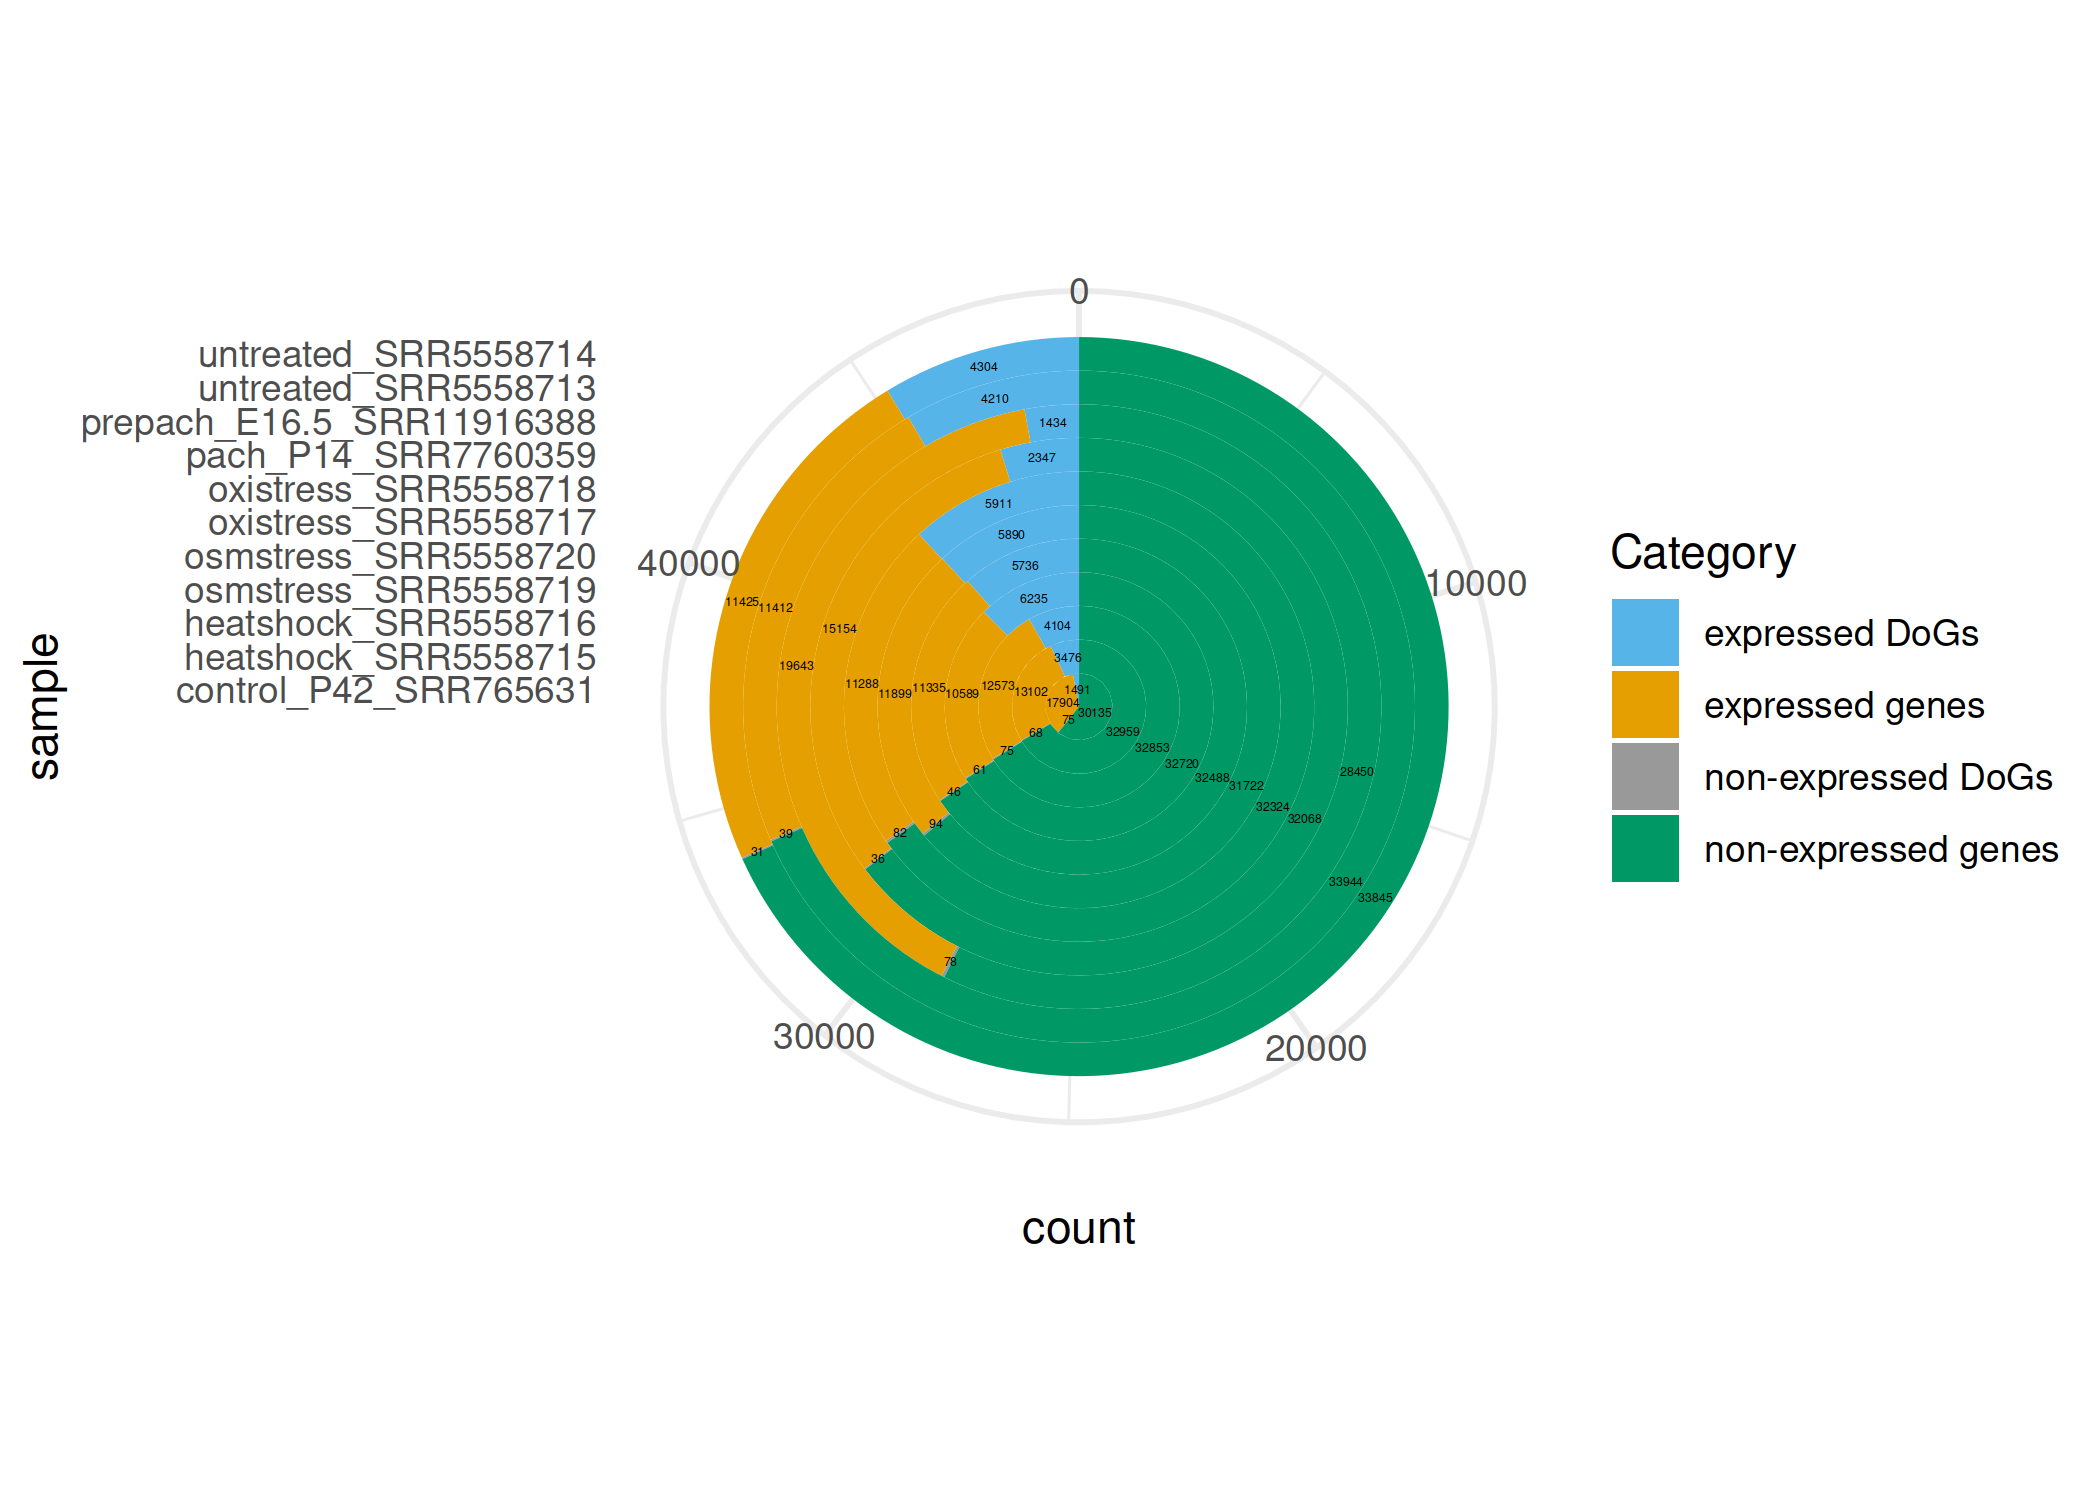

In [47]:
pdf("pie.pdf",height=5,width=7)
pie
dev.off()
pie

In [48]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 300)
bar <- ggplot(res2, aes(x=count, y=sample,fill=group))+
  geom_col() +
  geom_text(aes(label = count,x=count),
           position = position_stack(vjust = 0.5),
           size=2)+
  scale_fill_brewer(palette="Set3") +
  theme_minimal()

png 
  2

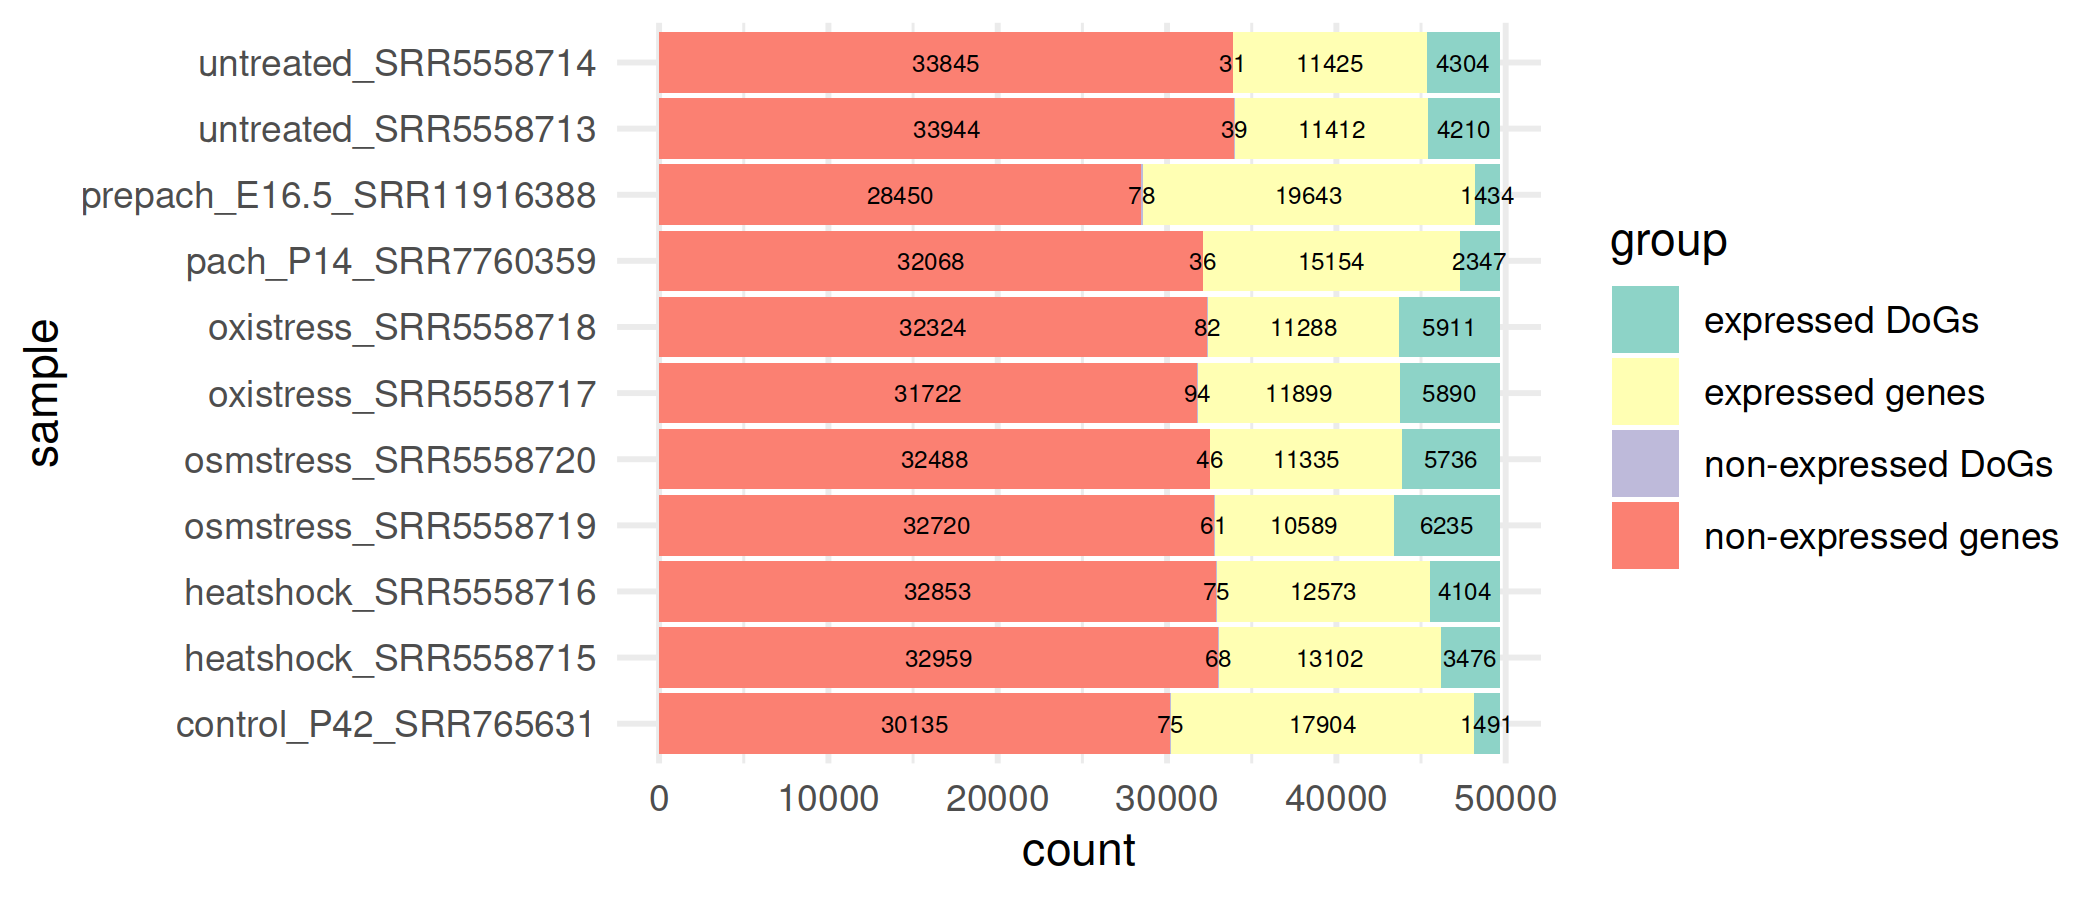

In [49]:
pdf("bar.pdf",height=3,width=7)
bar
dev.off()
bar

#### Length of DoGs

In [50]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)
library(scales) # to access break formatting functions

graph1 <- ggplot(all_dogs, aes(x=sample, y=log10(length), fill=sample)) + 
            geom_violin(width=1, scale="count") +
            geom_boxplot(width=0.2, color="grey36", alpha=0.6, outlier.shape = NA) +
            annotation_logticks(
                base = 10,
                sides = "l", 
                colour = "black") +
            theme_classic() + 
            coord_cartesian(ylim = c(2.7, 5.2)) +
            scale_fill_brewer(palette="Set3") +
            labs(title = "Log10 Transformed Violin Plot of nucleotide length of DoGs", y = "Log10(length of DoG)") + 
            theme(text=element_text(size=10,  family="Helvetica"), legend.position = "none",
                  axis.text.x = element_text(angle=90,hjust=1,vjust=0.5,size=6)
                 )+
            stat_compare_means(ref.group="prepach_E16.5_SRR11916388",aes(label = ..p.signif..))

png 
  2

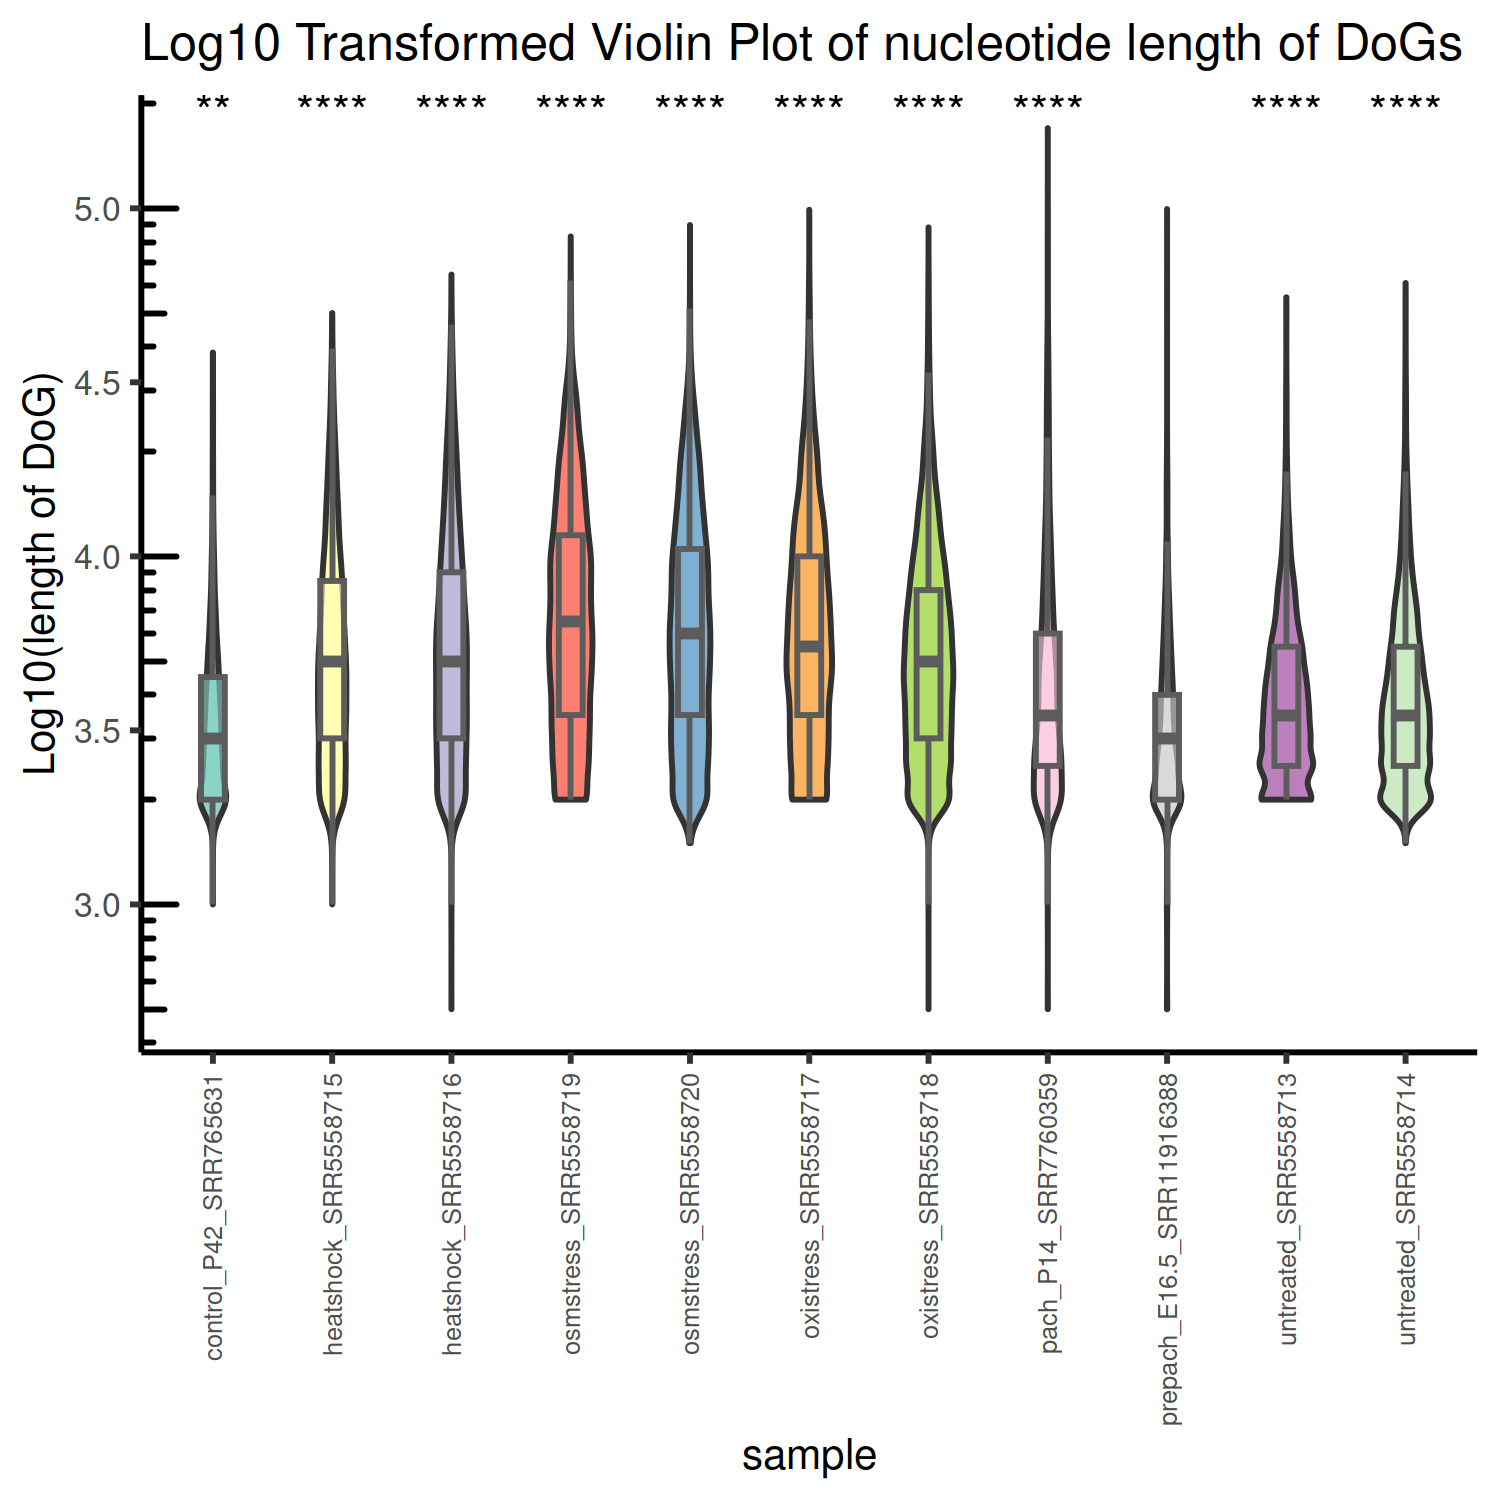

In [51]:
pdf("DoGs_lengths.pdf",height=5,width=5)
graph1
dev.off()
graph1

In [52]:
res4 <- res %>% filter(DoGs=="Yes")

### genes with DoGs overlaped with top1000 Picluster

Warning message:
“Removed 129 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 129 rows containing non-finite values (`stat_compare_means()`).”


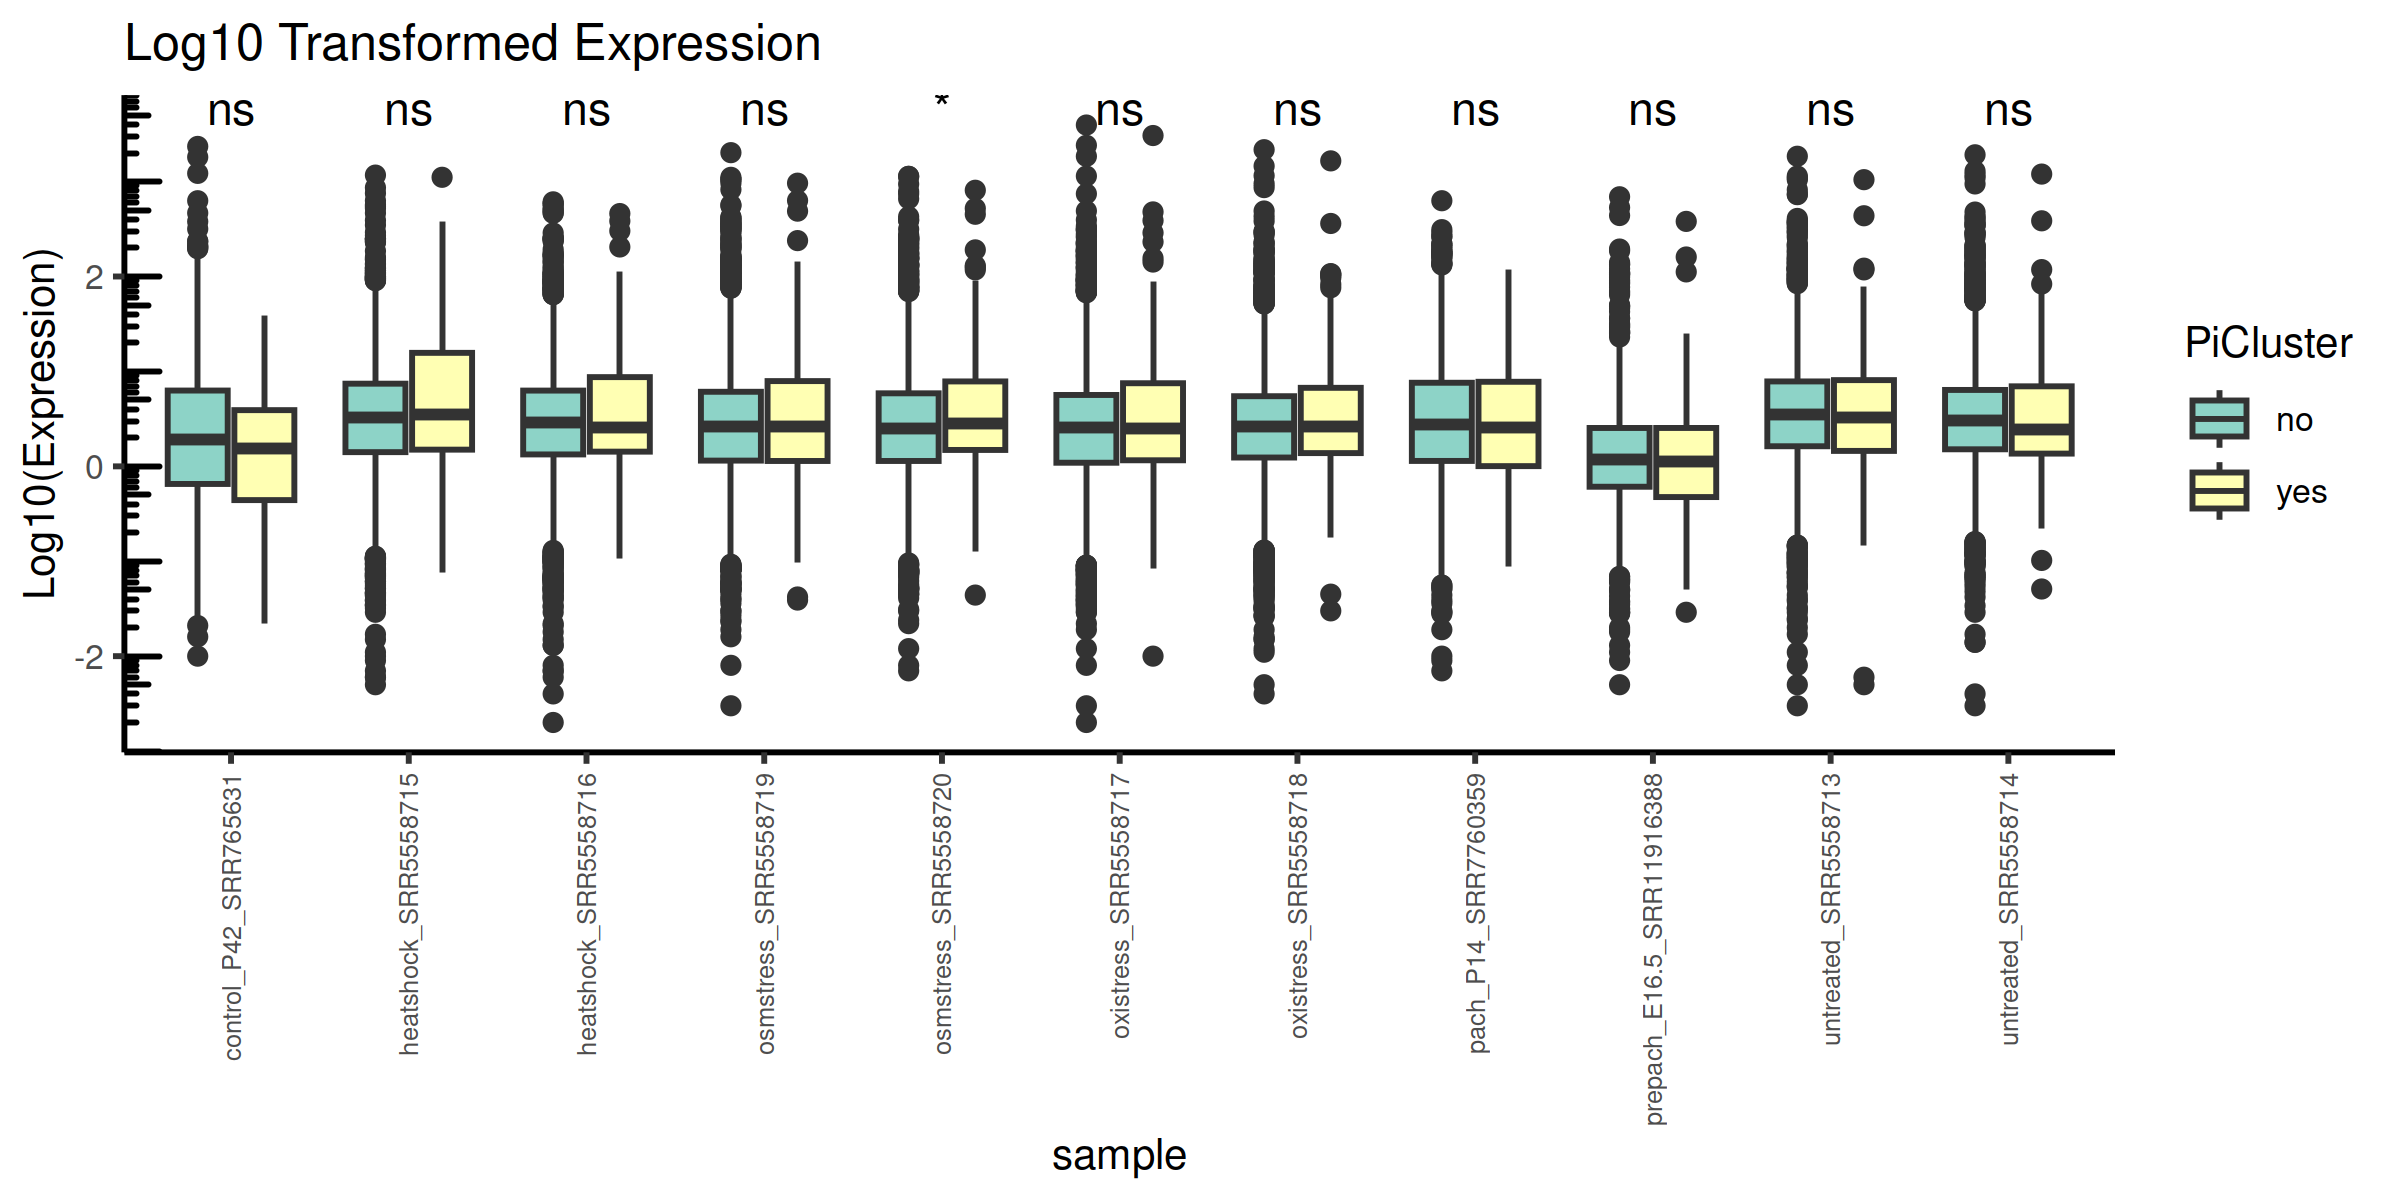

In [53]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)
graph2 <- ggplot(res4, aes(x=sample, y=log10(value), fill=PiCluster)) + 
            #geom_violin() +
            geom_boxplot() +
            annotation_logticks(
                base = 10,
                sides = "l", 
                colour = "black") +
            theme_classic() + 
            #coord_cartesian(ylim = c(2.7, 5.2)) +
            scale_fill_brewer(palette="Set3") +
            labs(title = "Log10 Transformed Expression", y = "Log10(Expression)") +
            theme(text=element_text(size=10,  family="Helvetica"), 
                  axis.text.x = element_text(angle=90,hjust=1,vjust=0.5,size=6)
                 ) +
            stat_compare_means(aes(group = PiCluster,label = ..p.signif..))

graph2

### lengths of DoGs overlapped with or without top1000 Piclusters

In [54]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)
graph3 <- ggplot(res4, aes(x=sample, y=log10(length), fill=PiCluster)) + 
            #geom_violin() +
            geom_boxplot() +
            annotation_logticks(
                base = 10,
                sides = "l", 
                colour = "black") +
            theme_classic() + 
            #coord_cartesian(ylim = c(2.7, 5.2)) +
            scale_fill_brewer(palette="Set3") +
            labs(title = "Log10 Transformed Length", y = "Log10(Length)") +
            theme(text=element_text(size=10,  family="Helvetica"), 
                  axis.text.x = element_text(angle=90,hjust=1,vjust=0.5,size=6)
                 ) +
            stat_compare_means(aes(group = PiCluster,label = ..p.signif..))

png 
  2

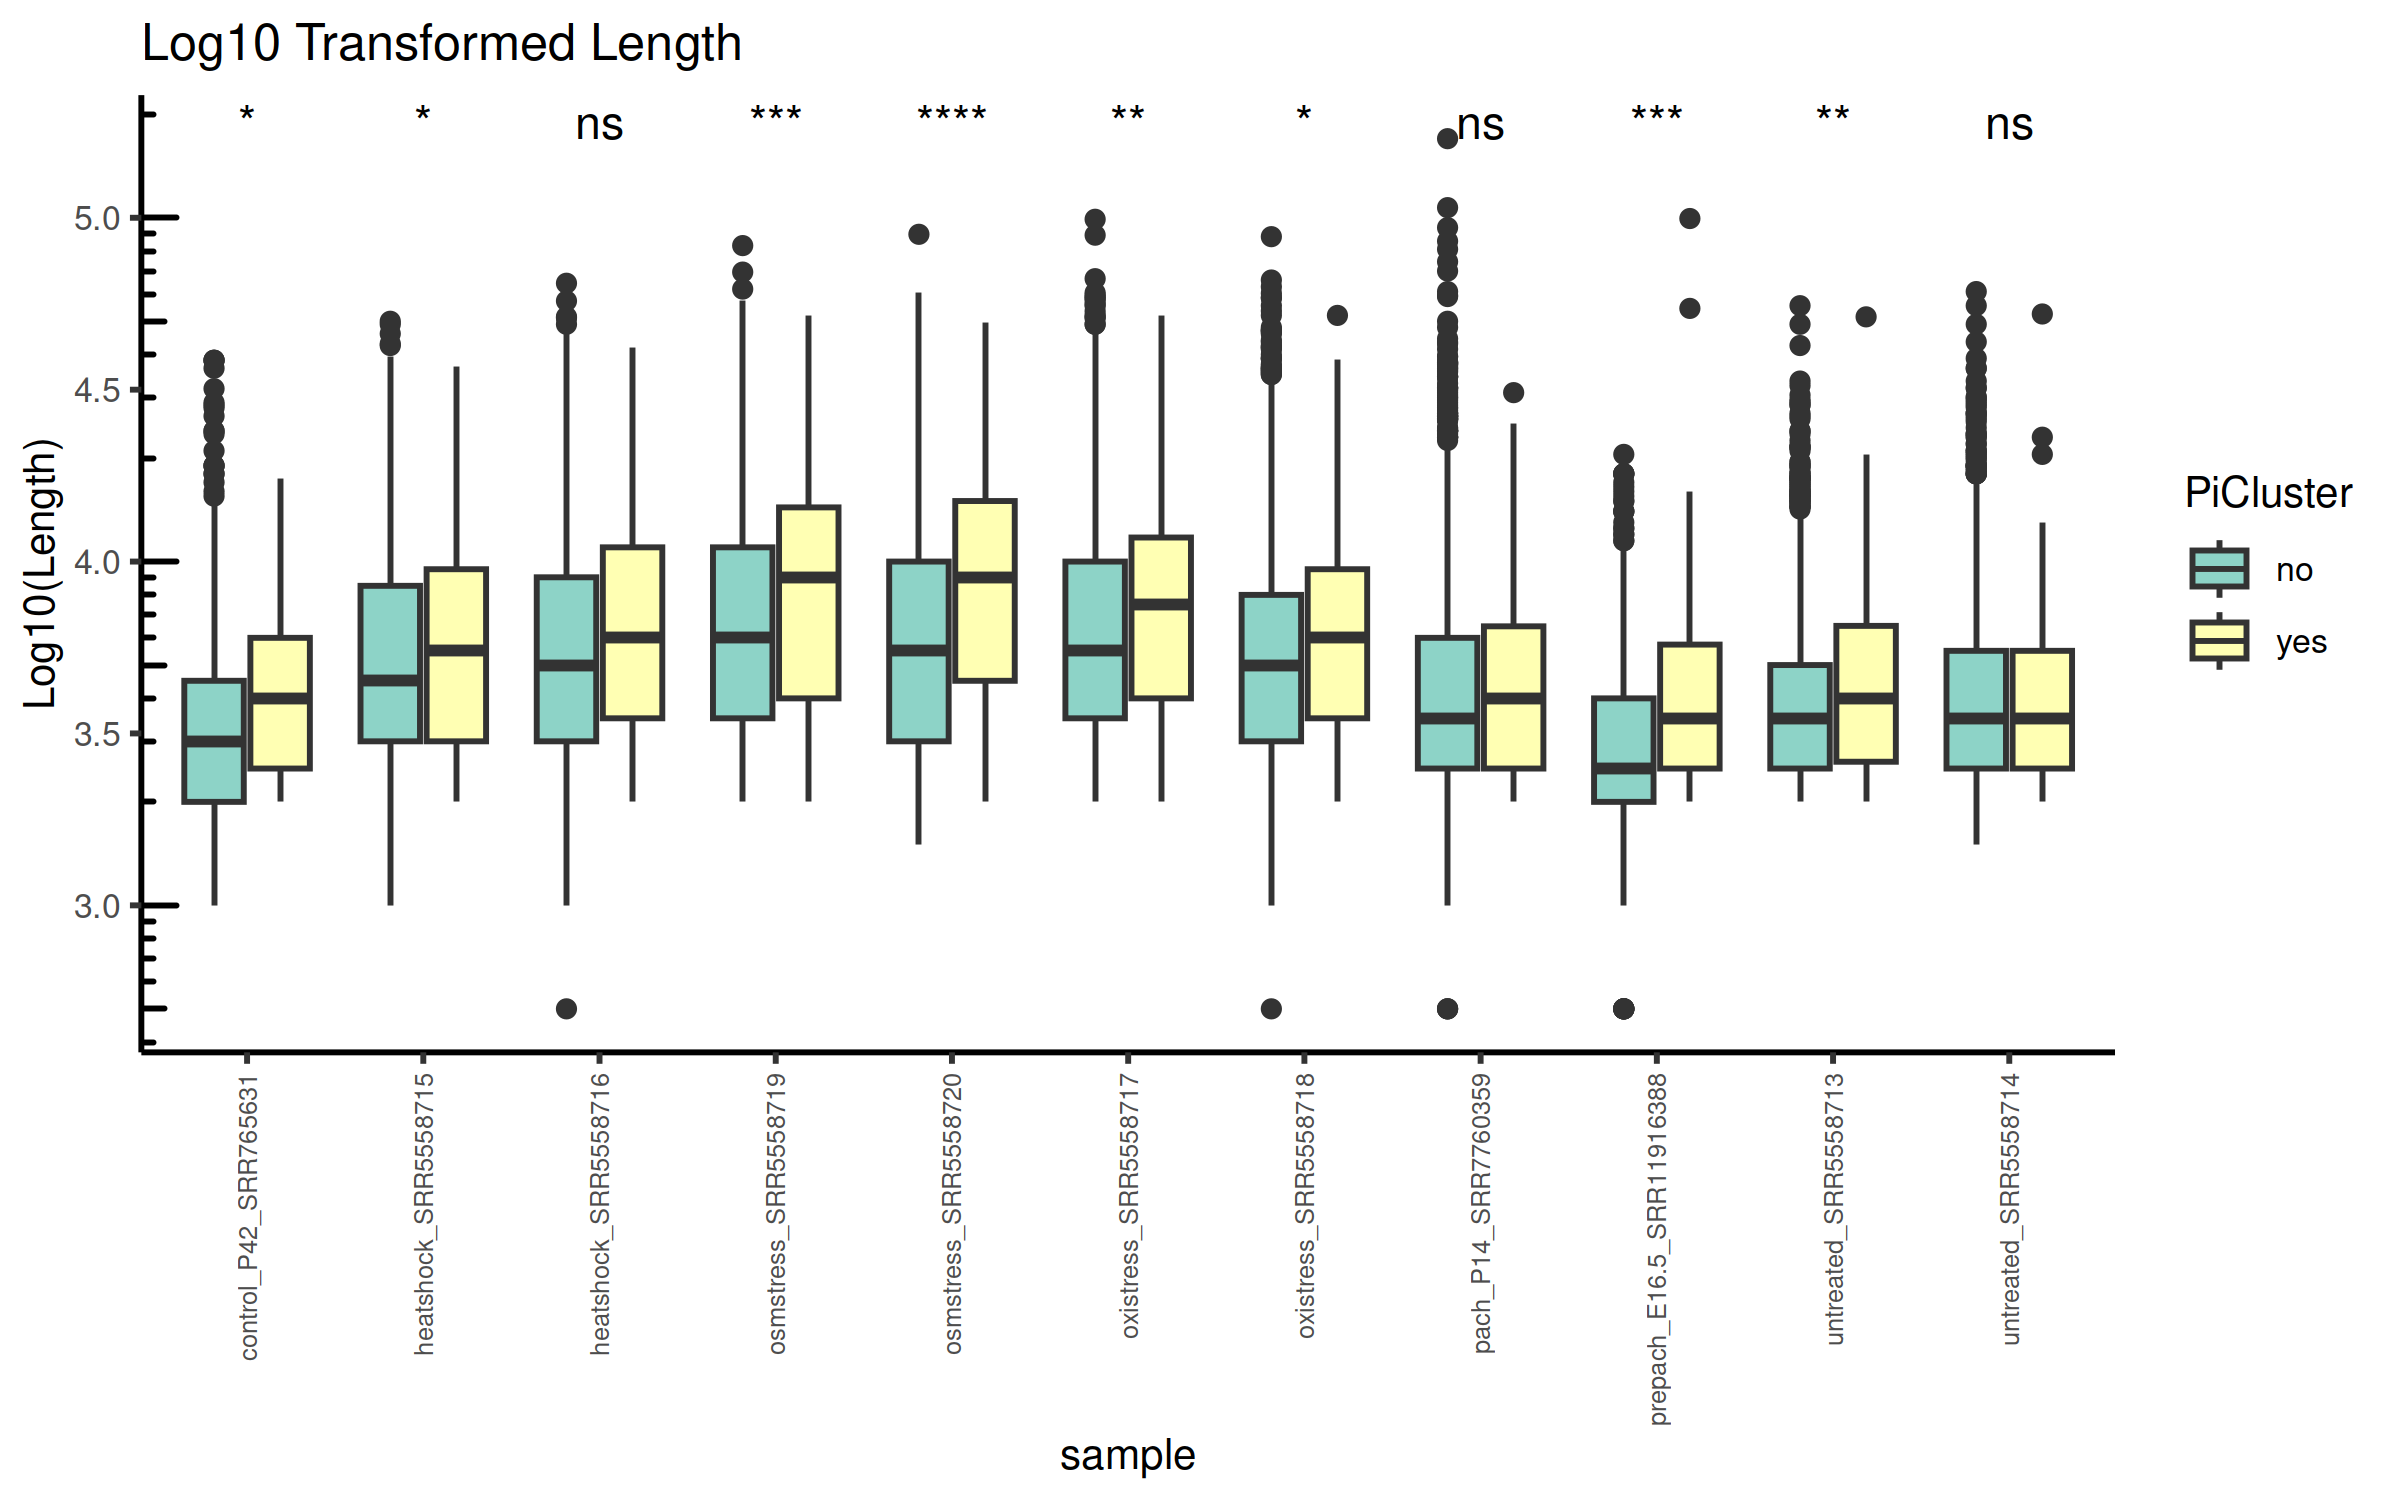

In [55]:
pdf("DoGs_overlapped_with_top1000_Piclusters.pdf",height=5,width=8)
graph3
dev.off()
graph3

In [56]:
res4$group2 <- case_when(res4$expr == "expressed" & res4$PiCluster=="yes" ~ "expressed DoGs in PiClusters",
                       res4$expr == "expressed" & res4$PiCluster=="no" ~ "expressed DoGs not in PiClusters",
                       res4$expr == "non-expressed" & res4$PiCluster=="yes" ~ "non-expressed DoGs in PiClusters",
                       res4$expr == "non-expressed" & res4$PiCluster=="no" ~ "non-expressed DoGs not in PiClusters"
)

In [57]:
res5 <- res4 %>% 
group_by(sample,group2)  %>%
summarize(count=n())

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


In [58]:
res6 <- res5 %>% pivot_wider(names_from = group2, values_from = count)
res6

sample,expressed DoGs in PiClusters,expressed DoGs not in PiClusters,non-expressed DoGs in PiClusters,non-expressed DoGs not in PiClusters
<chr>,<int>,<int>,<int>,<int>
control_P42_SRR765631,38,1453,4,71
heatshock_SRR5558715,111,3365,2,66
heatshock_SRR5558716,112,3992,1,74
osmstress_SRR5558719,163,6072,3,58
osmstress_SRR5558720,152,5584,1,45
oxistress_SRR5558717,139,5751,4,90
oxistress_SRR5558718,134,5777,2,80
pach_P14_SRR7760359,58,2289,1,35
prepach_E16.5_SRR11916388,75,1359,5,73


In [59]:
# enrichment analysis of DoGs genes
rownames(res6) <- res6$sample
apply(res6[,-1], 1, function(x) fisher.test(matrix(as.numeric(x[1:4]), ncol=2, byrow=T)))

Warning message:
“Setting row names on a tibble is deprecated.”


[[1]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value = 0.1379
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1606344 1.8410136
sample estimates:
odds ratio 
 0.4645316 


[[2]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2831007 9.2912101
sample estimates:
odds ratio 
  1.088534 


[[3]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value = 0.7233
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.3540348 83.8106392
sample estimates:
odds ratio 
  2.075889 


[[4]]

	Fisher's Exact Test for Count Data

data:  matrix(as.numeric(x[1:4]), ncol = 2, byrow = T)
p-value = 0.2169
alternative hypothesis: true odds ratio is not equal to 1
95 percent confi

### identify common peaks from two replicates

In [ ]:
## linux
module load bedtools
module load homer

bedtools intersect -a ARTDeco_stress_output/dogs/mmu_NIH3TR_heatshock_SRR5558715_Aligned.sortedByCoord.out.dogs.bed -b ARTDeco_stress_output/dogs/mmu_NIH3TR_heatshock_SRR5558716_Aligned.sortedByCoord.out.dogs.bed|sort -u >heatshock.bed
bedtools intersect -a ARTDeco_stress_output/dogs/mmu_NIH3TR_osmstress_SRR5558719_Aligned.sortedByCoord.out.dogs.bed -b ARTDeco_stress_output/dogs/mmu_NIH3TR_osmstress_SRR5558720_Aligned.sortedByCoord.out.dogs.bed|sort -u >osmstress.bed
bedtools intersect -a ARTDeco_stress_output/dogs/mmu_NIH3TR_oxistress_SRR5558717_Aligned.sortedByCoord.out.dogs.bed -b ARTDeco_stress_output/dogs/mmu_NIH3TR_oxistress_SRR5558718_Aligned.sortedByCoord.out.dogs.bed|sort -u >oxistress.bed
bedtools intersect -a ARTDeco_stress_output/dogs/mmu_NIH3TR_untreated_SRR5558713_Aligned.sortedByCoord.out.dogs.bed -b ARTDeco_stress_output/dogs/mmu_NIH3TR_untreated_SRR5558714_Aligned.sortedByCoord.out.dogs.bed|sort -u >untreated.bed

### Finding Overlapping DoGs between stress and E16.5

In [ ]:
for i in heatshock.bed osmstress.bed oxistress.bed
do
	file=`basename $i .bed`
	mergePeaks ${i} E16.5.bed -prefix E16.5_vs_${file} -matrix $file.matrix -venn ${file}_venn
	Rscript multi_peaks_Venn.R ${file} ${file}_venn
done